In [2]:
import darshan
from darshan.experimental.plots.heatmap_handling import *
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Any, Tuple, Sequence, TYPE_CHECKING

import sys

if sys.version_info >= (3, 8):
    from typing import TypedDict
else:
    from typing_extensions import TypedDict


import numpy as np

if TYPE_CHECKING:
    import numpy.typing as npt

In [3]:
def get_rd_wr_dfs_with_offset(
    report: Any, 
    ops: Sequence[str] = ["read", "write"], 
    mod: str = "DXT_POSIX", 
) -> Dict[str, pd.DataFrame]:
    
    dict_list = report.records[mod].to_df()
    rd_wr_dfs = {}
    # iterate over each operation
    for op_key in ops:
        # mypy can't tell that these keys are in fact
        # in the ``SegDict``, so just ignore the type
        seg_key = op_key + "_segments"
        # create empty list to store each dataframe
        df_list = []
        # iterate over all records/dictionaries
        for _dict in dict_list:
            # ignore for the same reason as above
            seg_df = _dict[seg_key]  # type: ignore
            if seg_df.size:
                # create new column for the ranks
                seg_df["rank"] = _dict["rank"]
                # add the dataframe to the list
                df_list.append(seg_df)

        if df_list:
            # concatenate the list of pandas dataframes into
            # a single one with new row indices
            rd_wr_dfs[op_key] = pd.concat(df_list, ignore_index=True)
        else:
            # if the list is empty assign an empty dataframe
            rd_wr_dfs[op_key] = pd.DataFrame()

    return rd_wr_dfs
    
    

### Load Darshan Log

In [4]:
# Load some report data
#
filepath_2k = "/homes/yll6162/darshan/darshan-logs/2022/12/3/\
yll6162_file_iter_l_name_id1418668-1418668_12-3-4627-11471487188351852929_1.darshan"

filepath_4m = "/homes/yll6162/darshan/darshan-logs/2022/12/5/\
yll6162_file_iter_l_name_id1908991-1908991_12-5-83826-12425478679868356432_1.darshan"

with darshan.DarshanReport(filepath_4m, read_all=False) as report:

    # Load some report data
    # report.mod_read_all_records('DXT_POSIX')
    # report.mod_read_all_records('MPI-IO')
    # or fetch all
    report.mod_read_all_dxt_records('DXT_POSIX')

    # ...
    # Generate summaries for currently loaded data
    # Note: aggregations are still experimental and have to be activated:
    darshan.enable_experimental()
    dxt_df_dict = get_rd_wr_dfs_with_offset(report = report, ops = ["read"])
    dxt_df = dxt_df_dict['read']
    # rd_wr_dfs = get_rd_wr_dfs()
    


### Data Preprocessing 

##### Merge blocks

In [5]:
def merge_block(dxt_df):
    block_ct = 0
    df = dxt_df.sort_values(by = "offset", axis = 0).reset_index(names = "ori_index")
    size = len(df)
    new_reads = []
    df["block_index"] = -1
    i = 0
    
    while i < size:
        # print(i)
        tot = df.loc[i, "length"]
        start = df.loc[i, "offset"]
        df.loc[i, "block_index"] = block_ct
        while (i < size - 1) and (start + tot >= df.loc[i + 1, "offset"]):
            tot = df.loc[i + 1, "offset"] + df.loc[i + 1, "length"] - start
            df.loc[i + 1, "block_index"] = block_ct
            i += 1
        i += 1
        block_ct += 1
        new_reads.append((start, tot, block_ct))
        # new_reads.append((start, tot))
    merged_df = pd.DataFrame(new_reads, columns = ["offset", "length", "block_index"])
    return merged_df, df


test_df = dxt_df[dxt_df.offset < 50000]
merged_df, dxt_df_label  = merge_block(dxt_df)
dxt_df_label


,ori_index,offset,length,start_time,end_time,rank,block_index
0,0,0,8,0.000824,0.000826,0,0
1,1,0,16,0.000836,0.000837,0,0
2,2,16,80,0.000838,0.000838,0,0
3,3,96,512,0.000851,0.000851,0,0
4,6,136,544,0.000912,0.000912,0,0
...,...,...,...,...,...,...,...
1489,1490,284880,512,0.006814,0.006814,0,0
1490,1485,285016,328,0.006793,0.006793,0,0
1491,1491,285344,512,0.006819,0.006819,0,0
1492,1474,285480,352,0.006751,0.006752,0,0


##### File offset heat 

In [10]:
def file_offset_heatmap(dxt_df):
    start = 0
    dxt_df["end_offset"] = dxt_df.offset + dxt_df.length
    start = min(dxt_df["offset"])
    # end = max(dxt_df["end_offset"])
    end = 12246848
    cols = ["offset", "read_freq"]
    data = np.zeros((end - start + 1, 2))
    
    heat_df = pd.DataFrame(columns = cols, data = data)
    heat_df["offset"] = np.arange(start, end + 1)
    heat_df.set_index("offset", inplace = True)
    
    size = len(dxt_df)
    i = 0
    
    while i < size:
        
        offset = dxt_df.loc[i, "offset"]
        length = dxt_df.loc[i, "length"]
        
        
        heat_df.loc[offset : offset+length + 1, "read_freq"] += 1
        i += 1
    heat_df["read_freq"] = heat_df.read_freq.astype(int)
    return heat_df.reset_index()
        
    

heat_df = file_offset_heatmap(dxt_df)
heat_df  
    
    

,offset,read_freq
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2
...,...,...
12246844,12246844,0
12246845,12246845,0
12246846,12246846,0
12246847,12246847,0


### Visualiztion

#### Raw read segments

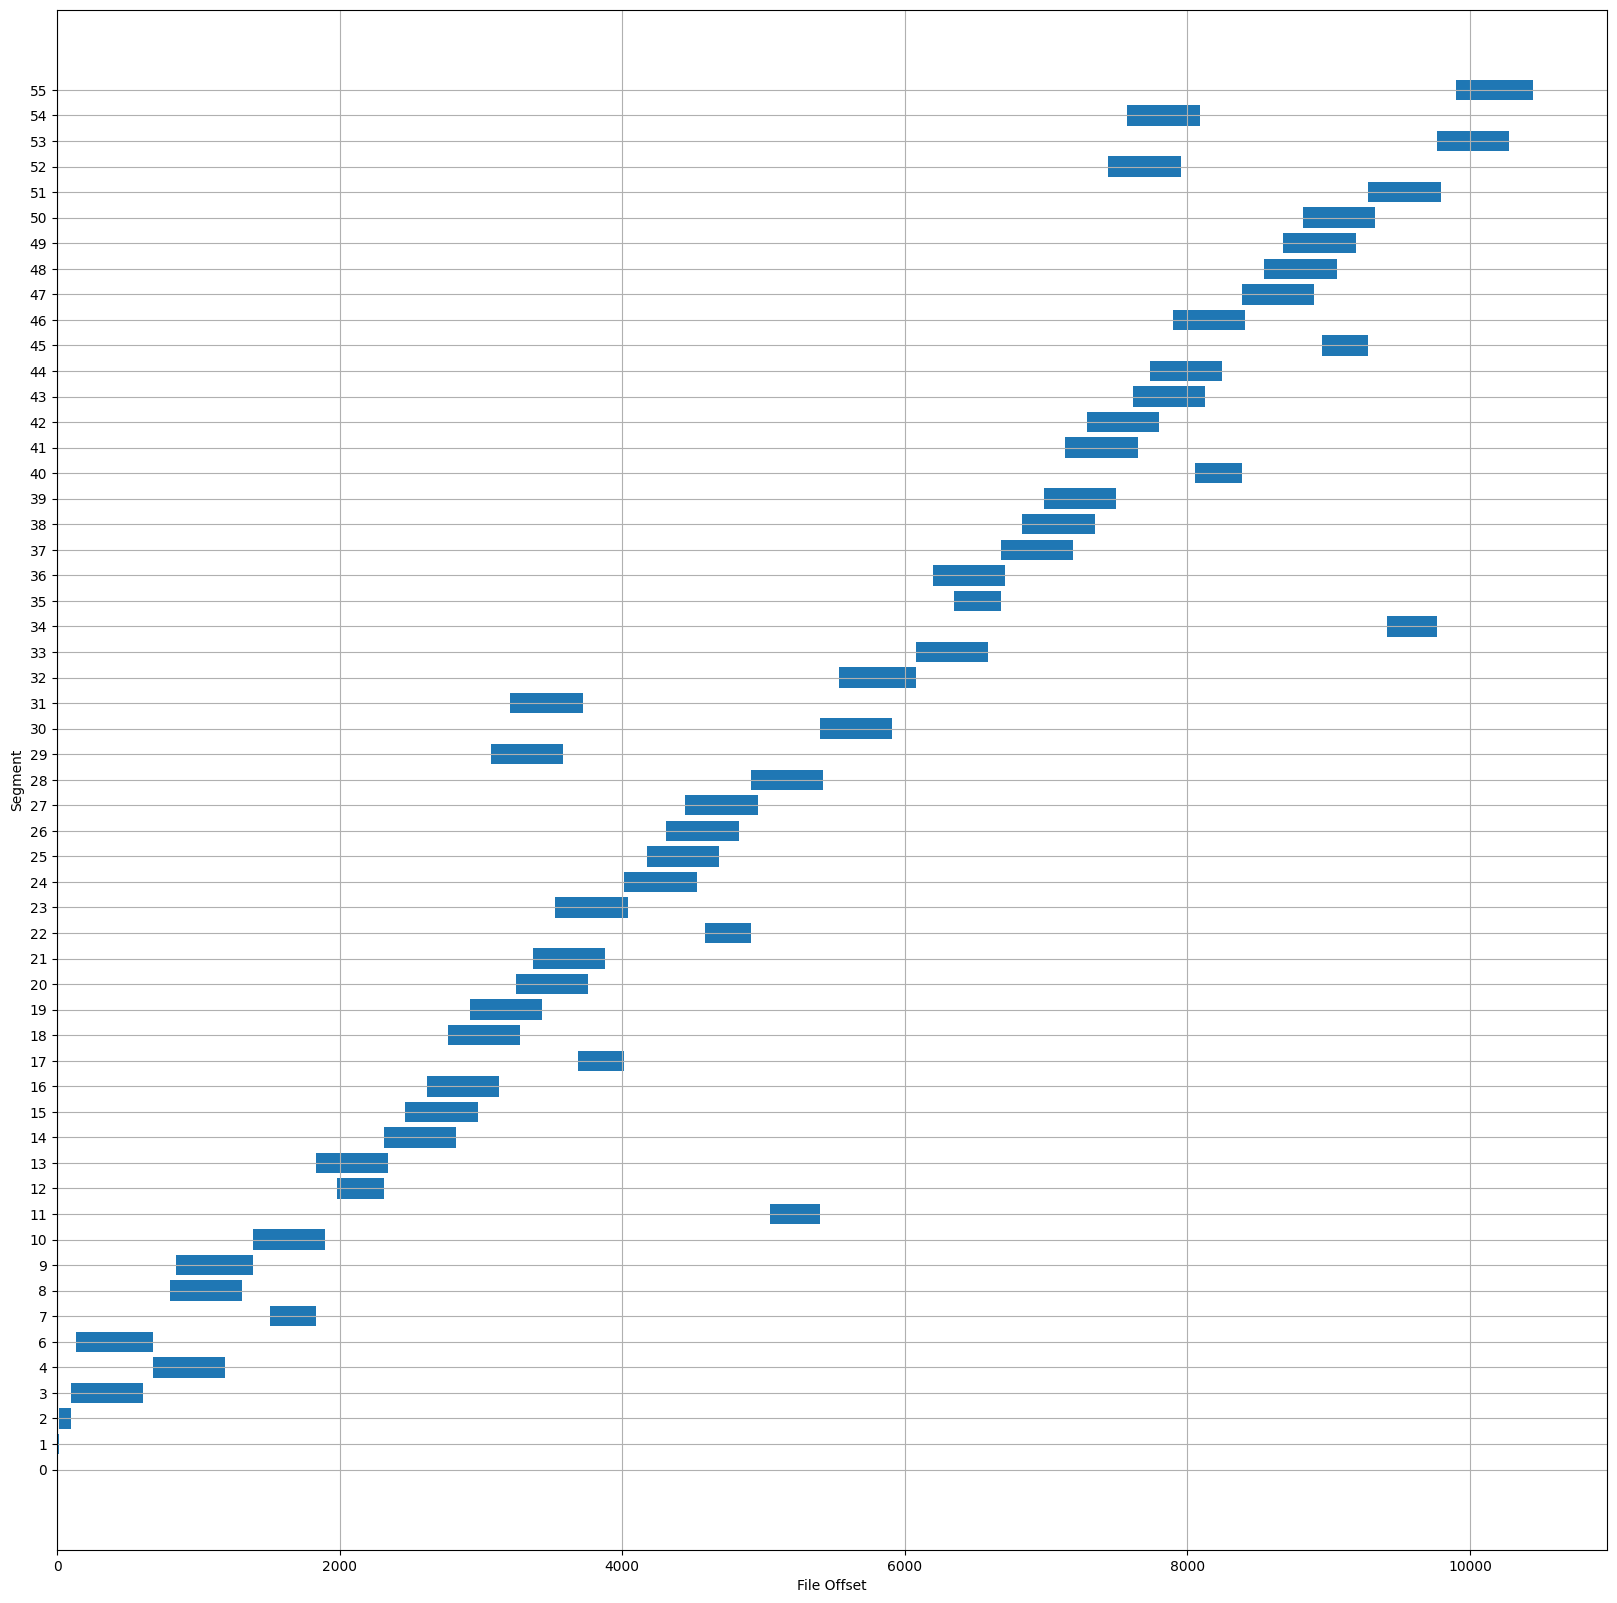

In [9]:


#sample bar chart for unmerged reads
nr = 1
nc = 1

fig, ax = plt.subplots(figsize = (20, 20))
block_i = 0 

df_plot = dxt_df_label[dxt_df_label.offset < 10000].sort_values(by = "ori_index")
# ax[i, j].barh(df_plot.ori_index.astype(str), df_plot.length, left = df_plot.offset, height = 0.06 * len(df_plot))
ax.barh(df_plot.ori_index.astype(str), df_plot.length, left = df_plot.offset)
# ax[i, j].set_yticks(list(range(min(df_plot.index), max(df_plot.index) + 1)))
ax.grid(True)
ax.set_xlabel('File Offset')
ax.set_ylabel('Segment')
block_i += 1


plt.show()
filename = f"dxt_darshan_raw_segments_{nr * nc}_samples_4mb.png"
fig.savefig("figure/" + filename)
        


# ax.barh(list(test_df.index), test_df.length, left = test_df.offset, height = 0.4)
# # ax.set_xticks([0, 500, 1000, 40000, 45000, 50000])
# # ax.set_xscale('log')
# ax.set_yticks(list(range(test_df.index[0], test_df.index[-1] + 1)))
# plt.grid(True)
# plt.show()

# plt.bar(courses, values, width = 0.4)


##### File offset heatmap



In [81]:
heat_df.read_freq.unique()

array([2, 1, 3, 0, 4, 5])

/homes/yll6162/.local/lib/python3.9/site-packages/matplotlib/image.py:175: UserWarning: Data with more than 2**23 columns cannot be accurately displayed. Downsampling to less than 2**23 columns before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**23 columns'))


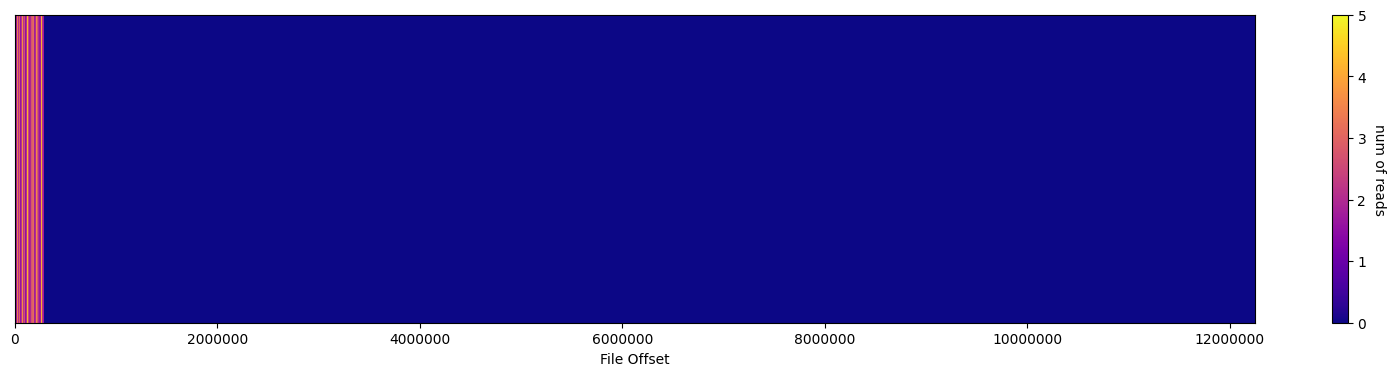

In [11]:
##### File offset heatmap

start = min(heat_df.offset)
end = max(heat_df.offset)
fig, ax = plt.subplots(figsize = (20,4))

im = ax.imshow(heat_df[["read_freq"]].values[np.newaxis,:], cmap="plasma", aspect="auto")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("num of reads", rotation=-90, va="bottom")
ax.set_xlim(start, end)
ax.set_yticks([])
ax.set_xlabel("File Offset")
ax.ticklabel_format(style='plain')
# ax.set_xticks([round((end - start) / n * i  + start) for i in range(n)])

filename = f"dxt_darshan_file_offset_heatmap_4mb.png"
fig.savefig("figure/" + filename)

#### Merged read segments

In [12]:
merged_df.head()

,offset,length,block_index
0,0,286344,1


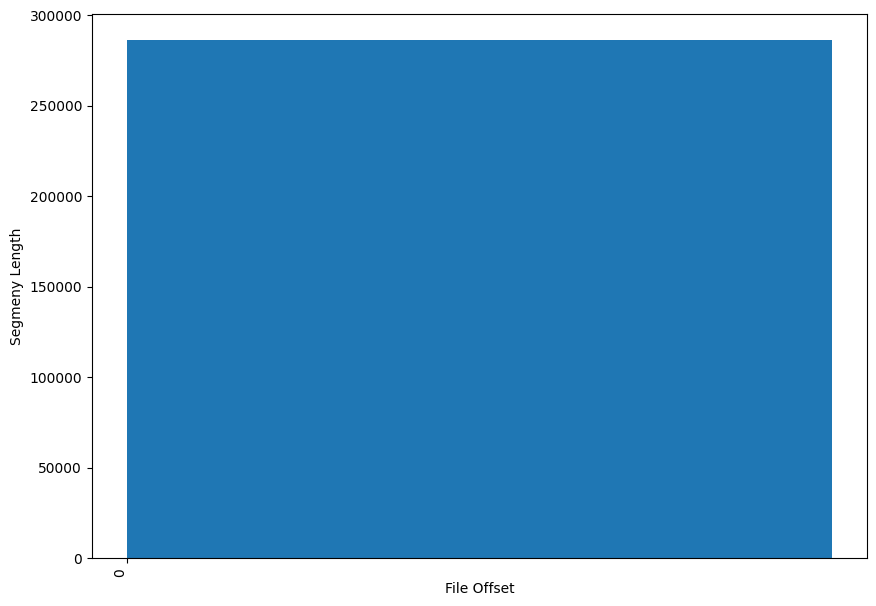

In [14]:
#sample bar chart for unmerged reads
# nr = 4
# nc = 4

# fig, ax = plt.subplots(nr, nc, figsize = (20, 20))
# block_i = 0 
# for i in range(0, nr):
#     for j in range(0, nc):
#         df_plot = merged_df[merged_df.block_index == block_i + 1]
#         ax[i, j].barh(df_plot.index.astype(str), df_plot.length, left = df_plot.offset, height = 0.01)
#         # ax[i, j].barh(df_plot.index.astype(str), df_plot.length, left = df_plot.offset)
#         # ax[i, j].set_yticks(list(range(min(df_plot.index), max(df_plot.index) + 1)))
#         ax[i, j].grid(True)
#         ax[i, j].set_xlabel('File Offset')
#         ax[i, j].set_ylabel('Merged Segment')
#         block_i += 1

# plt.show()
fig, ax = plt.subplots(figsize = (10, 8))

ax.bar(merged_df.offset.astype(str), merged_df.length, align="edge", )
ax.set_xlabel('File Offset')
ax.set_ylabel('Segmeny Length')
plt.margins(tight = True)
fig.autofmt_xdate(rotation = 90)
filename = f"dxt_darshan_merged_blocks_bar_4mb.png"
fig.savefig("figure/" + filename)


        